In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os, sys, re

from collections import Counter
from itertools import chain

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

## Load Data
Files to load: all (`os.listdir` with model specified) vs specific list

Note: `reference` might also contain non test files - filter out

In [4]:
def name_adapt(s:str, extra_patterns:list=[]):
    extra_patterns += ['finetuned', '.csv']
    for p in extra_patterns:
        s = s.replace(p,'')
    # replace adjacent '-' / '_' with only one
    return re.sub('[-_]{1,}','-',s)


In [122]:
dataset = "hcrc_maptask"
data_folder = f"../data/{dataset}"
gf_reference = "microsoft-DialoGPT-small_file_1024.csv"
model_patterns = ['rnn', 'gpt']
data_paths = {
    ("reference" if x == gf_reference else name_adapt(x,[dataset])):x for x in os.listdir(data_folder) if any([y in x.lower() for y in model_patterns])
}

In [123]:
gpt_ctx_nopivot = [k for k,v in data_paths.items() if 'c0-8.csv' in v]
if len(gpt_ctx_nopivot) > 0:
    gpt_c08l = pd.read_csv(os.path.join(data_folder, data_paths.pop(gpt_ctx_nopivot[0])))
data_paths

{'microsoft-dialogpt-small-maptask-cf': 'microsoft-dialogpt-small-maptask-cf.csv',
 'microsoft-dialogpt-ds-test': 'microsoft-dialogpt-ds-test.csv',
 'gpt2-en-maptask-file-1024': 'gpt2-en-maptask-finetuned_file_1024.csv',
 'reference': 'microsoft-DialoGPT-small_file_1024.csv',
 'gpt2-en-maptask-maptask-ds': 'gpt2-en-maptask-finetuned-maptask-ds.csv',
 'microsoft-DialoGPT-small-maptaskc0-8-p': 'microsoft-DialoGPT-small-maptaskc0-8-p.csv',
 'microsoft-DialoGPT-small-no-context': 'microsoft-DialoGPT-small_no-context.csv'}

In [124]:
df = {}
for k,v in data_paths.items():
    tmp = pd.read_csv(os.path.join(data_folder,v))
    if 'model' not in tmp.columns: # typically: reference
        tmp['model'] = k
    df[k] = tmp

res = pd.concat(df.values(), axis=0)

In [125]:
models = res.model.unique()
models

array(['microsoft-dialogpt-small-context_ 000—bs8',
       'microsoft-dialogpt-small-context_<|endoftext|>000—bs8',
       'microsoft-dialogpt-small-context_<|endoftext|>100—bs8',
       'microsoft-dialogpt-ds-test', 'gpt2-en-maptask-file-1024',
       'reference', 'gpt2-en-maptask-finetuned-ds', '_0', '_1', '_2',
       '_3', '_4', '_5', '_6', '_7',
       'microsoft-DialoGPT-small-no-context'], dtype=object)

Removing files not analysed for every model:

In [126]:
#if 'reference' in res.model.unique():
#    test_files = res[res.model != 'reference'].file.unique()
#    res = res[res.file.isin(test_files)]
res_files = Counter(chain(*[res[res.model == model].file.unique() for model in res.model.unique()]))
res_files = [k for k,v in res_files.items() if v == len(models)]
res = res[res.file.isin(res_files)]

In [110]:
res.head()

file speaker  theme_id transaction_type  move_number    move_type  index  \
0  q1ec1       g         1           normal            1        ready      1   
1  q1ec1       g         1           normal            2     instruct      2   
2  q1ec1       f         1           normal            1  acknowledge      3   
3  q1ec1       g         1           normal            3     instruct      4   
4  q1ec1       f         1           normal            2        check      5   

   theme_index  duration                                               text  \
0            1    0.3294                                               okay   
1            2    3.1785           starting off we are above a caravan park   
2            3    0.3459                                              mmhmm   
3            4    9.7612  we are going to go due south straight south an...   
4            5    1.5487                   due south and then back up again   

   ...                                             tokens      xu_h  \
0  ...                                             ['ay']  1.042326   
1  ...  [' starting', ' off', ' we', ' are', ' above',...  0.691912   
2  ...                                 [' mm', 'h', 'mm']  0.646917   
3  ...  [' we', ' are', ' going', ' to', ' go', ' due'...  0.553799   
4  ...  [' due', ' south', ' and', ' then', ' back', '...  0.615966   

                                       model text_input_ids text_u_full  \
0  microsoft-dialogpt-small-context_ 000—bs8            NaN         NaN   
1  microsoft-dialogpt-small-context_ 000—bs8            NaN         NaN   
2  microsoft-dialogpt-small-context_ 000—bs8            NaN         NaN   
3  microsoft-dialogpt-small-context_ 000—bs8            NaN         NaN   
4  microsoft-dialogpt-small-context_ 000—bs8            NaN         NaN   

  text_input_ids_full input_ids start_idx attention_mask   h  
0                 NaN       NaN       NaN            NaN NaN  
1                 NaN       NaN       NaN            NaN NaN  
2                 NaN       NaN       NaN            NaN NaN  
3                 NaN       NaN       NaN            NaN NaN  
4                 NaN       NaN       NaN            NaN NaN  

[5 rows x 36 columns]

In [61]:
res.isna().sum(axis=0)

file                            0
speaker                         0
theme_id                        0
transaction_type                0
move_number                     0
move_type                       0
index                           0
theme_index                     0
duration                        0
text                            0
context_0                   54165
text_u                      54165
context_1                   54165
context_2                   54165
context_3                   54165
context_4                   54165
context_5                   54165
context_6                   54165
context_7                   54165
context_ 000                54165
context_<|endoftext|>000    54165
context_<|endoftext|>100    54165
normalised_h                  170
length                          0
tokens_h                    27083
sum_h                       54277
tokens                      27083
xu_h                          170
model                           0
h             

In [21]:
length_by_file = res.groupby('file')['index'].max().to_dict()

## Plots

### Checking consistency

In [127]:
reference_name = 'reference'#'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'#'reference'

In [128]:
models = res.model.unique()
merge_cols = ['file', 'index', 'speaker', 'text']
int_cols = ['normalised_h', 'xu_h', 'length']
cols = merge_cols + int_cols
comparison_df = {}
if reference_name in models:
    ref = res[res.model == reference_name][cols]
    for model in models:
        c = pd.merge(left=ref, right=res[res.model == model][cols], left_on=merge_cols, right_on=merge_cols, suffixes=('_ref', '_mod')).dropna(axis=0, subset=['xu_h_mod'])
        print(f"Correlation for model {model}: normalised_h {c.normalised_h_ref.corr(c.normalised_h_mod)} - xu_h {c.xu_h_ref.corr(c.xu_h_mod)}")
        comparison_df[model] = c
    

Correlation for model microsoft-dialogpt-small-context_ 000—bs8: normalised_h 0.6556613740379789 - xu_h 0.5523840552100626
Correlation for model microsoft-dialogpt-small-context_<|endoftext|>000—bs8: normalised_h 0.8145095995737731 - xu_h 0.7415583807821953
Correlation for model microsoft-dialogpt-small-context_<|endoftext|>100—bs8: normalised_h 0.7270606064503616 - xu_h 0.638512002665588
Correlation for model microsoft-dialogpt-ds-test: normalised_h 0.8086685124960621 - xu_h 0.7329137750533709
Correlation for model gpt2-en-maptask-file-1024: normalised_h -0.1789678657596813 - xu_h -0.1374034838881395
Correlation for model reference: normalised_h 1.0 - xu_h 1.0
Correlation for model gpt2-en-maptask-finetuned-ds: normalised_h -0.15698662284416715 - xu_h -0.03429146496143419
Correlation for model _0: normalised_h 0.6691619949261488 - xu_h 0.6070529229529189
Correlation for model _1: normalised_h 0.5727206198406739 - xu_h 0.5456190472629523
Correlation for model _2: normalised_h 0.5781301

In [129]:
#comparison_name = 'microsoft-dialogpt-small-context_<|endoftext|>100—bs8'
#comparison_name = 'microsoft-dialogpt-ds-test'
comparison_name = 'gpt2-en-maptask-file-1024'

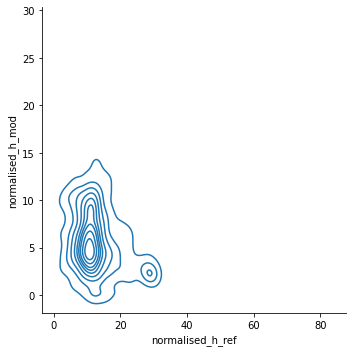

In [130]:
#sns.displot(data=comparison_df['gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'], x="normalised_h_ref", y="normalised_h_mod", kind="kde")
sns.displot(data=comparison_df[comparison_name], x="normalised_h_ref", y="normalised_h_mod", kind="kde")

And removing lines for which tokenizer leads to different results:

Correlation for model microsoft-DialoGPT-small-no-context: normalised_h 0.9923883696144306 - xu_h 0.9788719234927672


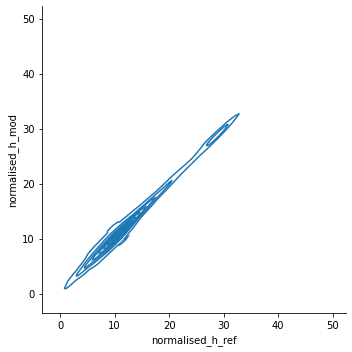

In [104]:
c = comparison_df[comparison_name]
c = c[c.length_ref == c.length_mod]
print(f"Correlation for model {model}: normalised_h {c.normalised_h_ref.corr(c.normalised_h_mod)} - xu_h {c.xu_h_ref.corr(c.xu_h_mod)}")
sns.displot(data=c, x="normalised_h_ref", y="normalised_h_mod", kind="kde")

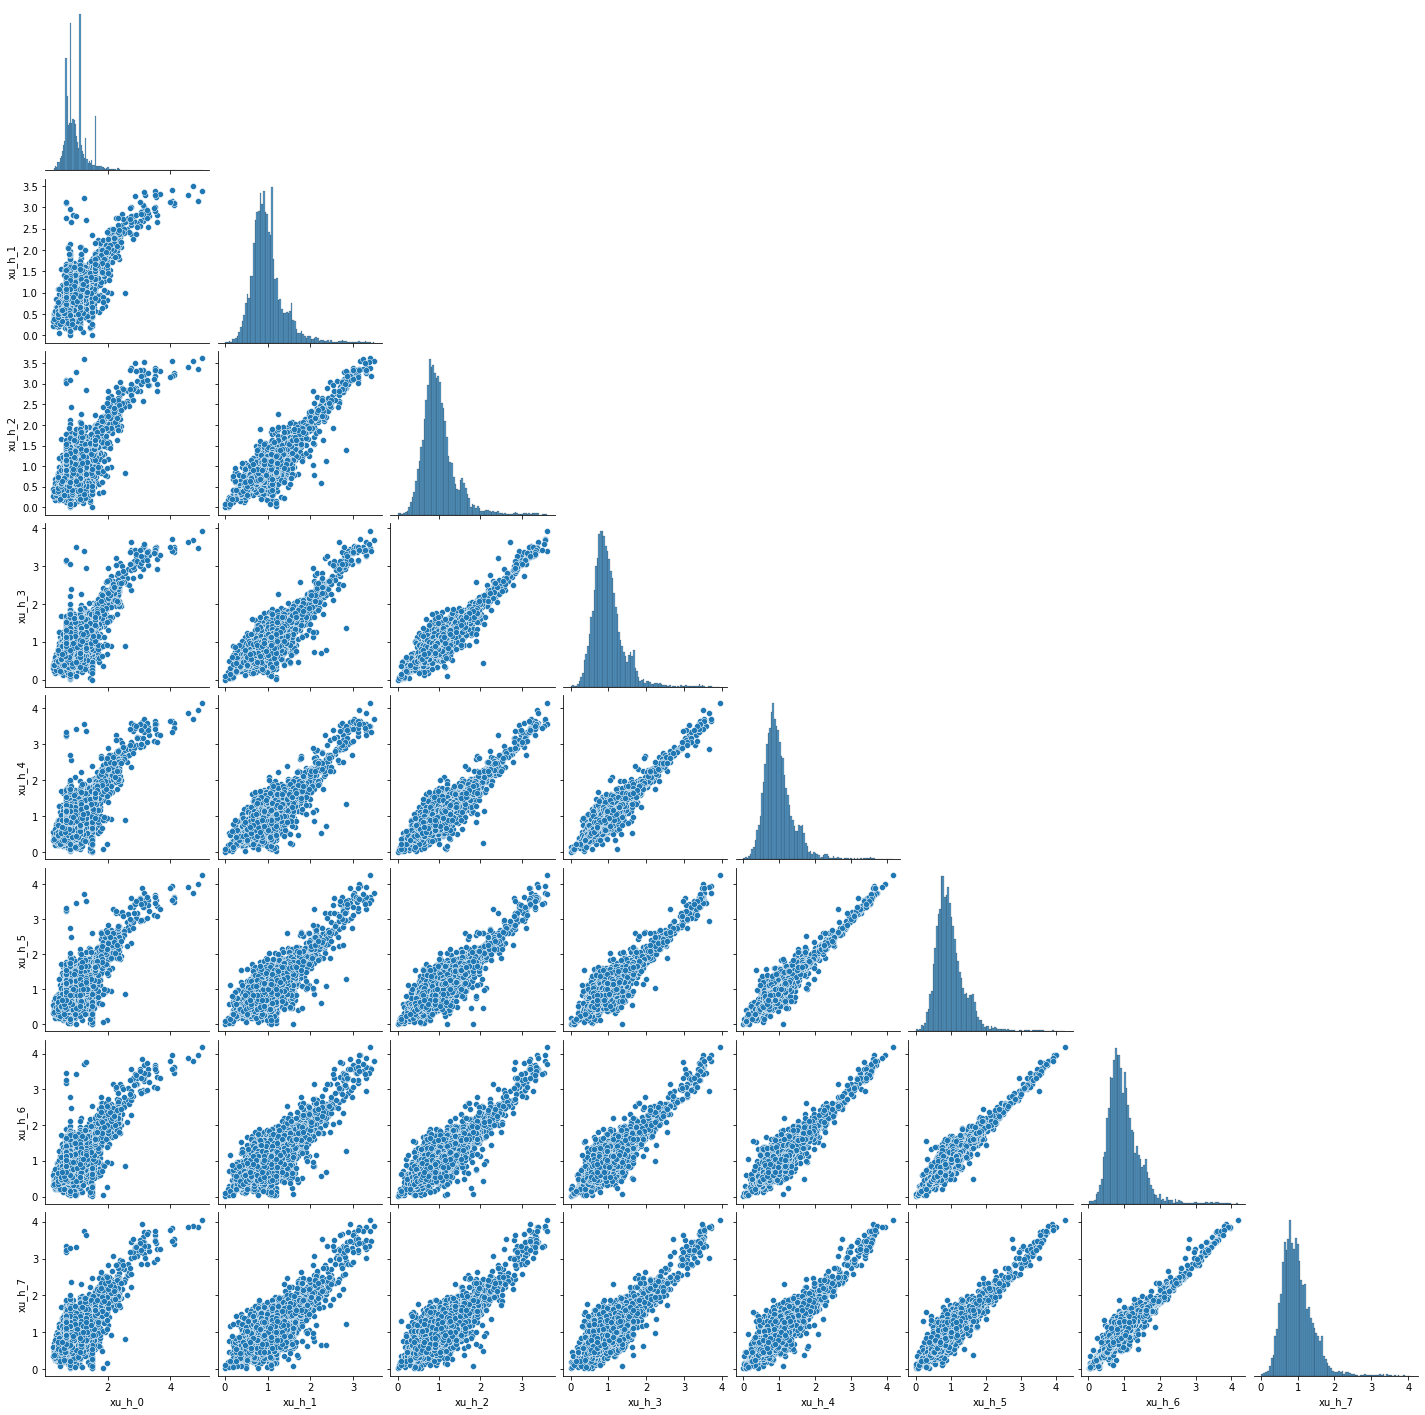

In [27]:
sns.pairplot(gpt_c08l, vars = [f'xu_h_{i}' for i in range(0,8)], corner=True)
plt.show()

### Generals

In [111]:
# keep for study
dialogs = res[res.model.isin([reference_name, comparison_name])]

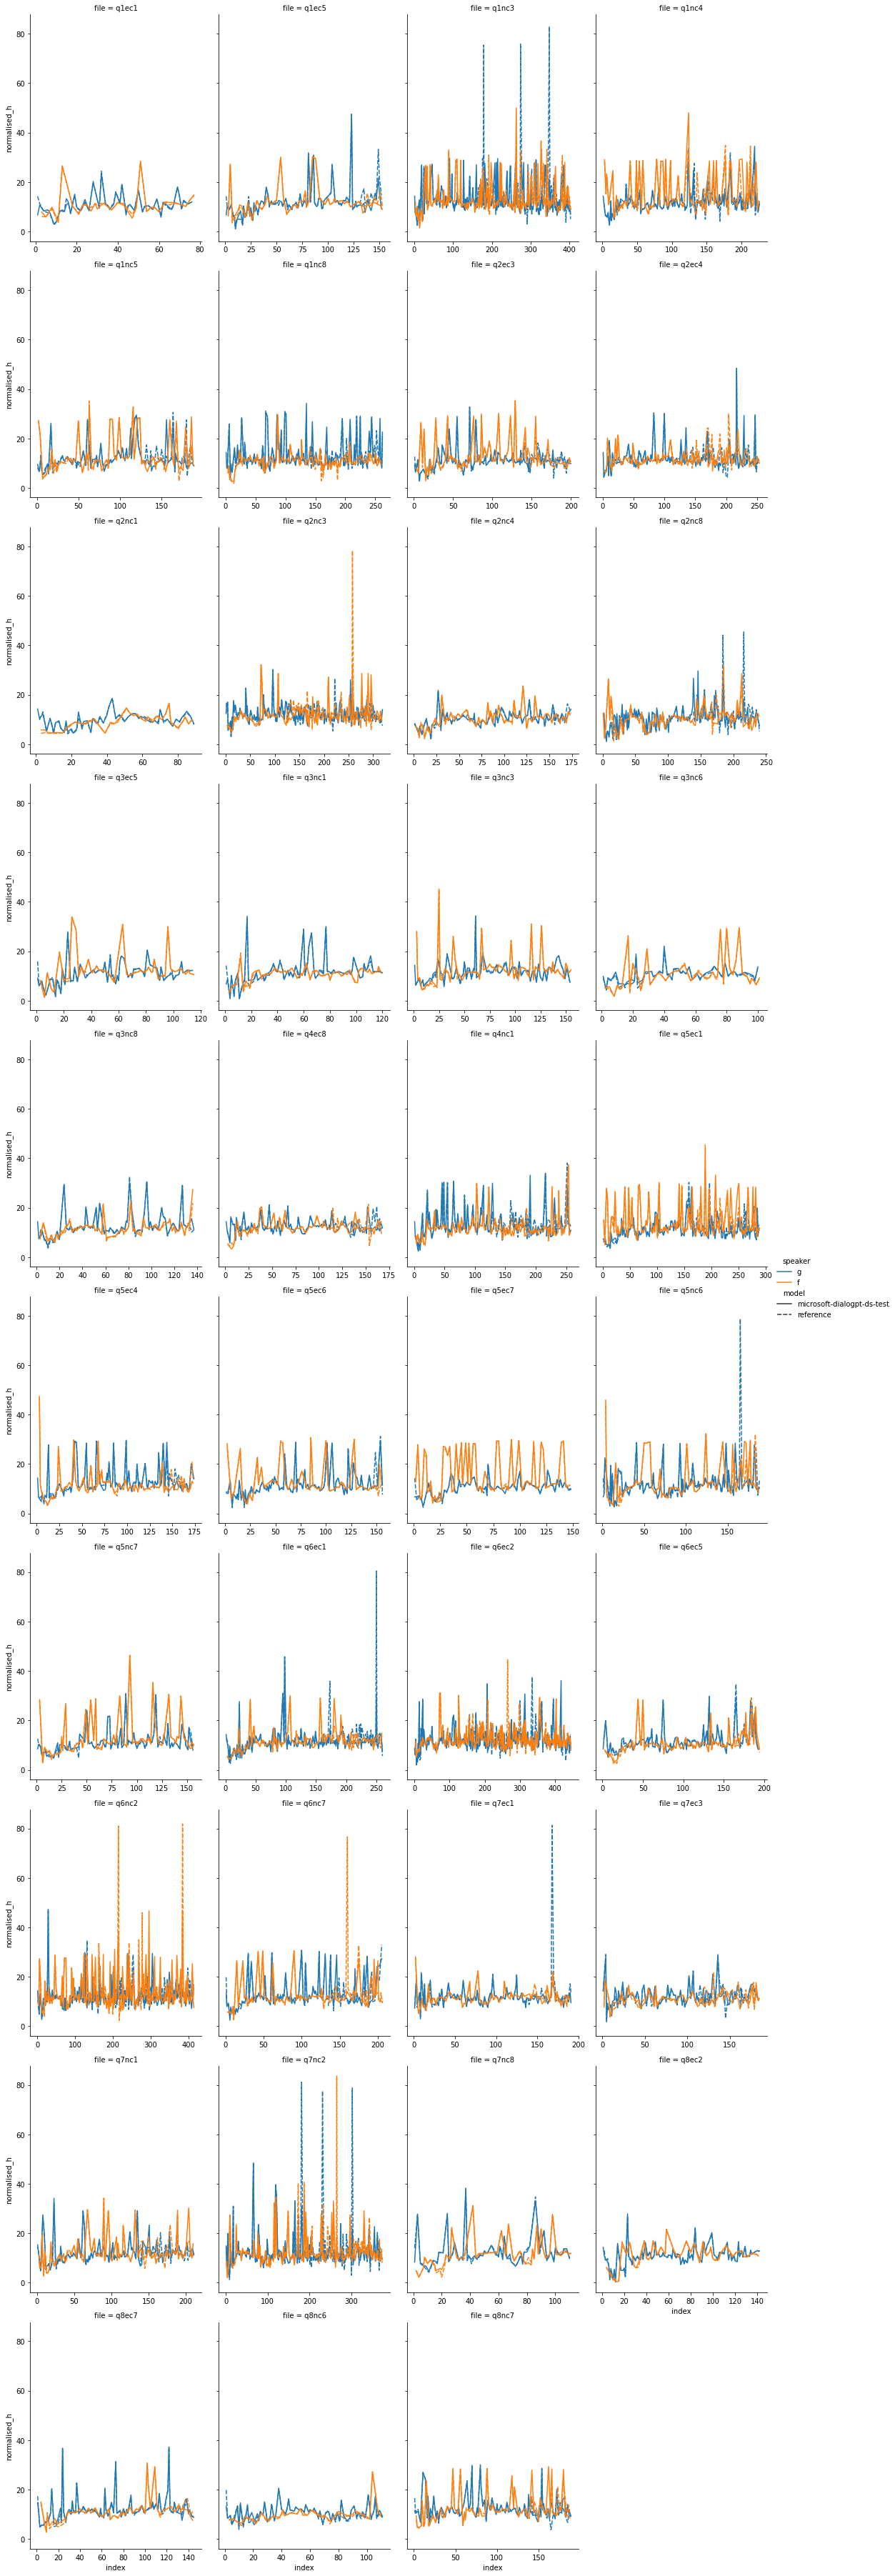

In [112]:
sns.relplot(
    data=dialogs,
    x="index", y="normalised_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

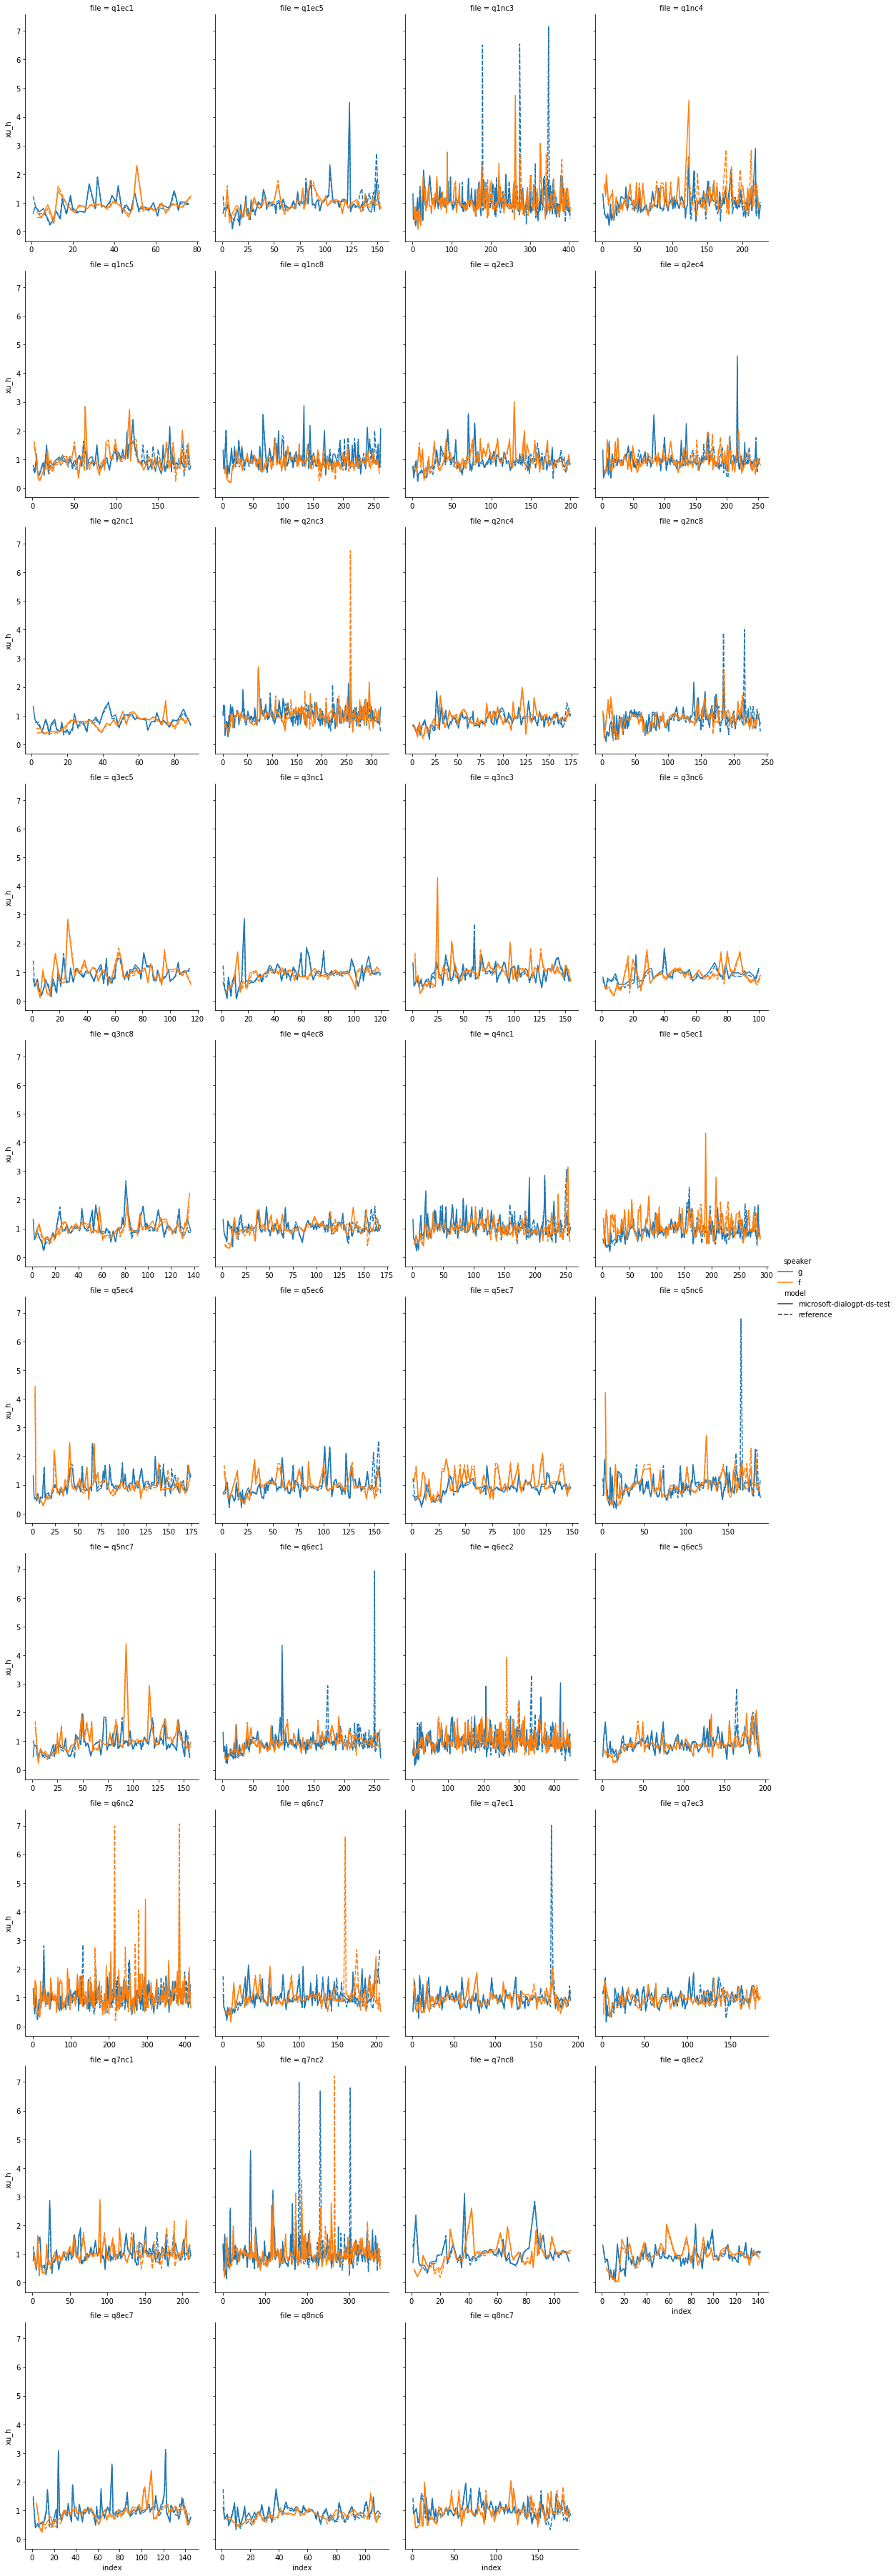

In [113]:
sns.relplot(
    data=dialogs,
    x="index", y="xu_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

### By episodes

Number of themes by file?

In [38]:
has_id_themes = 'theme_id' in dialogs.columns
theme_col = 'theme' if not has_id_themes else 'theme_id'

<AxesSubplot:ylabel='Density'>

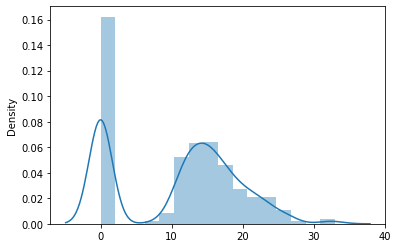

In [39]:
sns.distplot(dialogs.drop_duplicates(subset=['file',theme_col]).groupby('file').count())

In [115]:
# For the 2nd one: reindex => take the sign * max number
# Remove lines with extra transitions then for each one take the lines before / after and index and concat
# Note: issue with duplicated themes
not_transition = (dialogs[theme_col] != 'transition').astype(int)
#dialogs = dialogs[dialogs.theme != 'transition']
dialogs['theme_id'] = (dialogs[theme_col] != dialogs[theme_col].shift()).cumsum()
nb_in_ep = dialogs.groupby(['file', 'theme_id']).agg({'index': lambda x: range(len(x))}).explode('index')['index'].to_list()
inv_nb_in_ep = dialogs.groupby(['file', 'theme_id']).agg({'index': lambda x: range(-len(x),0)}).explode('index')['index'].to_list()
dialogs['count_after'] = nb_in_ep * not_transition
dialogs['count_before'] =  inv_nb_in_ep * not_transition

In [116]:
def compute_transitions_df(dialogs:pd.DataFrame, min_idx:int=10, max_idx:int=40, theme_col='theme'):
    # TODO: add checks on columns
    # remove_transitions
    dialogs = dialogs[dialogs[theme_col] != 'transition'].reset_index(drop=True)
    # get lines with 0
    new_themes = dialogs[dialogs.count_after == 0]
    if dialogs[theme_col].dtypes != int:
        new_themes['theme_id'] = range(new_themes.shape[0])

    final_df = []
    for idx, row in new_themes.iterrows():
        tmp = dialogs.iloc[max(0,idx-min_idx):min(dialogs.shape[0],idx+max_idx)]
        tmp['index'] = range(max(-min_idx,-idx), min(max_idx,dialogs.shape[0] - idx))
        # no need to check on file / model, done automatically
        tmp['ba'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else x.count_before, axis=1)
        tmp = tmp[tmp['index'] == tmp.ba]
        if dialogs[theme_col].dtypes != int:
            tmp['theme_id'] = row.theme_id
        # Add for plotting
        tmp['count_after'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else np.nan, axis=1)
        tmp['count_before'] = tmp.apply(lambda x: x.count_before if x['index'] <= 0 else np.nan, axis=1)
        # Add initiator / responder
        tmp['is_initiator'] = (tmp.speaker == row.speaker)
        # Add to df
        final_df.append(tmp)

    final_df = pd.concat(final_df, ignore_index=True)
    final_df['is_initiator'] = final_df.is_initiator.apply(lambda x: x * 'initiator' + (1 - x) * 'responder')
    return final_df

In [117]:
final_df = compute_transitions_df(dialogs, min_idx=5, max_idx=10, theme_col = theme_col)
final_df.shape

(16033, 40)

In [118]:
target_col = "normalised_h"

Differenciating between initiators and responders 

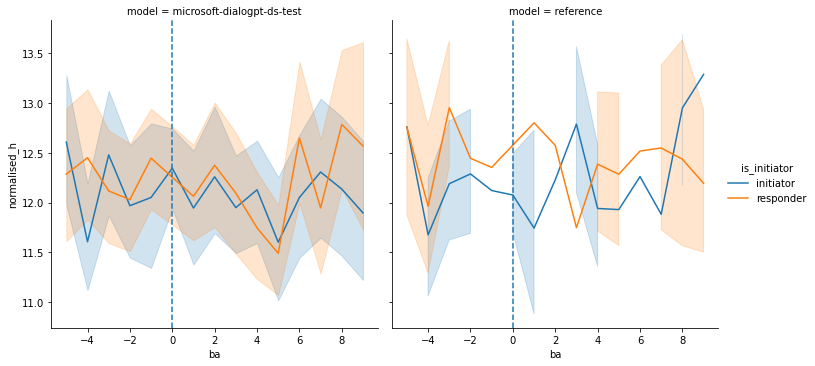

In [119]:
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')

Graph we want: apply `statsmodel` _before 0_ and _after 0_ and plot it on the same graph (with a scatterplot for the values)

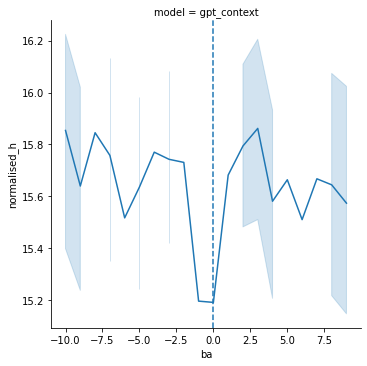

In [27]:
target_col = "normalised_h"
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model')
model_memory = {model:{} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        tmp = final_df[final_df.model == model].dropna(subset=[col])
        x = np.array([tmp['index'].min(), tmp['index'].max()])
        reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
        #print(model, col, reg_model.params) # .summary() for full summary of model
        g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], 'b')
        model_memory[model][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


In [120]:
target_col = "xu_h"

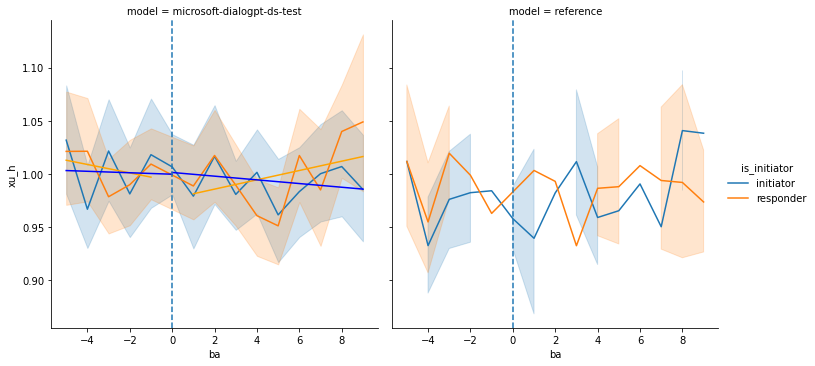

In [121]:
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
model_memory = {model:{spk:{} for spk in ['initiator','responder']} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        for spk, c in zip(['responder', 'initiator'], ['orange', 'b']):
            tmp = final_df[(final_df.model == model) & (final_df.is_initiator == spk)].dropna(subset=[col])
            x = np.array([tmp['index'].min(), tmp['index'].max()])
            reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
            #print(model, col, reg_model.params) # .summary() for full summary of model
            g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], c)
            model_memory[model][spk][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


Investigating a given model:
```python
for spk in ['initiator', 'responder']:
    print(f"\n-------------------{spk.upper()}------------------")
    print(model_memory['gpt_context'][spk]['count_after'].summary())
```

Data Exploration for one sentence

In [103]:
res[res.text == 'mh ouais si tu veux'][[col for col in res.columns if 'context_' not in col]]

corpus          file  dyad  index speaker  start     stop  \
1      cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
1      cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
3817   cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
7633   cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
11449  cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
15265  cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
19081  cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
22897  cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
26713  cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
1      cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
3817   cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
7633   cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
11449  cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
15265  cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   
19081  cheese  Cheese-AA_OR  AAOR      1      OR   5.14  5.82492   

                      text             theme theme_role  ...  has_theme  \
1      mh ouais si tu veux  hetero selection          f  ...       True   
1      mh ouais si tu veux  hetero selection          f  ...       True   
3817   mh ouais si tu veux  hetero selection          f  ...       True   
7633   mh ouais si tu veux  hetero selection          f  ...       True   
11449  mh ouais si tu veux  hetero selection          f  ...       True   
15265  mh ouais si tu veux  hetero selection          f  ...       True   
19081  mh ouais si tu veux  hetero selection          f  ...       True   
22897  mh ouais si tu veux  hetero selection          f  ...       True   
26713  mh ouais si tu veux  hetero selection          f  ...       True   
1      mh ouais si tu veux  hetero selection          f  ...       True   
3817   mh ouais si tu veux  hetero selection          f  ...       True   
7633   mh ouais si tu veux  hetero selection          f  ...       True   
11449  mh ouais si tu veux  hetero selection          f  ...       True   
15265  mh ouais si tu veux  hetero selection          f  ...       True   
19081  mh ouais si tu veux  hetero selection          f  ...       True   

               h  normalised_h  length  \
1      28.442576      4.063225       7   
1            NaN      4.212218       7   
3817         NaN      4.147302       7   
7633         NaN      4.147304       7   
11449        NaN      4.147297       7   
15265        NaN      4.147297       7   
19081        NaN      4.147301       7   
22897        NaN      4.147299       7   
26713        NaN      4.147299       7   
1            NaN      4.147297       7   
3817         NaN      4.147299       7   
7633         NaN      4.063222       7   
11449        NaN      4.063221       7   
15265        NaN      4.063222       7   
19081        NaN      4.063225       7   

                                                tokens_h  \
1      [-11.516682624816895, -0.17777733504772186, -3...   
1      [-11.058761596679688, -2.373636484146118, -3.6...   
3817   [-10.792609214782715, -0.26334744691848755, -4...   
7633   [-10.79261589050293, -0.2633468508720398, -4.2...   
11449  [-10.792576789855957, -0.263347864151001, -4.2...   
15265  [-10.792576789855957, -0.26334843039512634, -4...   
19081  [-10.792603492736816, -0.26334670186042786, -4...   
22897  [-10.79259204864502, -0.26334816217422485, -4....   
26713  [-10.79259204864502, -0.26334816217422485, -4....   
1      [-10.792593002319336, -0.2633475661277771, -4....   
3817   [-10.79259204864502, -0.26334816217422485, -4....   
7633   [-11.516683578491211, -0.17777658998966217, -3...   
11449  [-11.516680717468262, -0.17777733504772186, -3...   
15265  [-11.516683578491211, -0.17777658998966217, -3...   
19081  [-11.516688346862793, -0.17777809500694275, -3...   

                                                tokens      xu_h  \
1      ['m', 'h

In [97]:
tmp = comparison_df[comparison_name].dropna()

In [98]:
tmp['normalised_h_diff'] = (tmp.normalised_h_ref - tmp.normalised_h_mod).abs()/tmp.normalised_h_ref

In [99]:
tmp.sort_values(by='normalised_h_diff', ascending=False).head(20)

file  index speaker                                               text  \
2363  q2nc8     17       f                                               okay   
5868  q6nc2    217       f  i've got the sort of basic shape anyway so i s...   
2149  q2nc3    296       f                is it an u-- an u-- a "u"-turn or a   
6608  q7ec3    145       g  i've got lime stone cliffs which is the bottom...   
7907  q8nc7    165       g  over the summit down the right-hand side of it...   
5877  q6nc2    226       f                                       uh-huh right   
7225  q7nc2    366       g  go to the right about an inch and then draw an...   
802   q1nc4    169       g  the canal is about two inches to the left-hand...   
520   q1nc3    291       g  well you should curve just you you'll have to ...   
2143  q2nc3    290       f                                        acr-- right   
7159  q7nc2    300       g                                 ah okay oh are you   
522   q1nc3    293       g                                             uh-huh   
5256  q6ec2    244       g                                           told you   
1208  q1nc8    160       f                        you don't have those do you   
4577  q5nc6    170       f                                             uh-huh   
7133  q7nc2    274       g                                  v-- but that okay   
562   q1nc3    333       f                                             uh-huh   
1030  q1nc5    171       f                                            i don't   
781   q1nc4    148       g  and once you get to the where it says pine dra...   
5796  q6nc2    145       f                                             uh-huh   

      normalised_h_ref  xu_h_ref  length_ref  normalised_h_mod  xu_h_mod  \
2363          1.334070  0.117511         2.0          8.997726  0.855204   
5868          2.322731  0.200281         1.0         12.382504  1.002969   
2149          5.891948  0.508042         1.0         28.133431  2.175590   
6608          3.211297  0.276899         1.0         14.192241  1.071566   
7907          3.759123  0.324136         1.0         15.234112  1.284239   
5877          6.571548  0.566641         1.0         24.296775  1.979734   
7225          5.003920  0.409269         3.0         16.967571  1.374354   
802           4.176884  0.360158         1.0         13.837277  1.136265   
520           3.007655  0.259339         1.0          9.717919  0.806383   
2143          9.497540  0.818939         1.0         28.709291  1.560835   
7159          2.970427  0.256129         1.0          8.741218  0.712246   
522           9.248367  0.814636         2.0         27.148920  1.476002   
5256          4.722750  0.407226         1.0         13.791445  1.310831   
1208          2.858446  0.246474         1.0          8.275066  0.692191   
4577         10.946416  0.964207         2.0         29.180968  1.586478   
7133          9.020041  0.794524         2.0         23.951436  1.951595   
562          10.431857  0.918883         2.0         27.553792  1.498014   
1030          2.782476  0.239923         1.0          7.339161  0.616457   
781           4.927230  0.434012         2.0         12.971333  1.044499   
5796         11.049886  0.973322         2.0         29.089044  1.581481   

      length_mod  normalised_h_diff  
2363         2.0           5.744568  
5868        19.0           4.331012  
2149        15.0           3.774895  
6608        25.0           3.419474  
7907        14.0           3.052571  
5877         5.0           2.697268  
7225        19.0           2.390856  
802         22.0           2.312823  
520         13.0           2.231062  
2143         4.0           2.022813  
7159         5.0           1.942748  
522          4.0           1.935537  
5256         2.0           1.920215  
1208         7.0           1.894952  
4577         4.0           1.665801  
7133         5.0           1.655358  
562          4.0           1.641312  
1030         3.0        

In [101]:
file = 'q2nc8'
idx = 17
ba = 4

cond = (res.file == file) & (res['index'] >= idx-ba) & (res['index'] <= idx+ba) & (res.model.isin([reference_name, comparison_name]))

res[cond][[col for col in res.columns if ('context_' not in col) or (col == 'context_<|endoftext|>100')]]

file speaker  theme_id transaction_type  move_number    move_type  \
2359  q2nc8       f         1           normal            6        check   
2360  q2nc8       g         1           normal            8      reply_y   
2361  q2nc8       g         1           normal            9     instruct   
2362  q2nc8       g         1           normal           10        align   
2363  q2nc8       f         1           normal            7  acknowledge   
2364  q2nc8       g         2           normal           11     query_yn   
2365  q2nc8       f         2           normal            8      reply_n   
2366  q2nc8       g         2           normal           12  acknowledge   
2367  q2nc8       g         2           normal           13        ready   
7005  q2nc8       f         1           normal            6        check   
7006  q2nc8       g         1           normal            8      reply_y   
7007  q2nc8       g         1           normal            9     instruct   
7008  q2nc8       g         1           normal           10        align   
7009  q2nc8       f         1           normal            7  acknowledge   
7010  q2nc8       g         2           normal           11     query_yn   
7011  q2nc8       f         2           normal            8      reply_n   
7012  q2nc8       g         2           normal           12  acknowledge   
7013  q2nc8       g         2           normal           13        ready   

      index  theme_index  duration  \
2359     13           13    0.9559   
2360     14           14    0.2520   
2361     15           15    4.9421   
2362     16           16    0.2963   
2363     17           17    0.3740   
2364     18            1    1.9589   
2365     19            2    0.1581   
2366     20            3    0.4375   
2367     21            4    0.3718   
7005     13           13    0.9559   
7006     14           14    0.2520   
7007     15           15    4.9421   
7008     16           16    0.2963   
7009     17           17    0.3740   
7010     18            1    1.9589   
7011     19            2    0.1581   
7012     20            3    0.4375   
7013     21            4    0.3718   

                                                   text  ...  \
2359                              to the left-hand side  ...   
2360                                               yeah  ...   
2361  down until you're about an inch from the botto...  ...   
2362                                               okay  ...   
2363                                               okay  ...   
2364  now take it do you have a stone circle at the ...  ...   
2365                                                 no  ...   
2366                                       no you don't  ...   
2367                                               okay  ...   
7005                              to the left-hand side  ...   
7006                                               yeah  ...   
7007  down until you're about an inch from the botto...  ...   
7008                                               okay  ...   
7009                                               okay  ...   
7010  now take it do you have a stone circle at the ...  ...   
7011                                                 no  ...   
7012                                       no you don't  ...   
7013                                               okay  ...   

                                                 tokens      xu_h  \
2359      ['to', ' the', ' left', '-', 'hand', ' side']  1.654530   
2360                                           ['yeah']  0.811830   
2361  ['down', ' until', ' you', "'re", ' about', ' ...  0.413437   
2362                                       ['ok', 'ay']  0.326873   
2363                                       ['ok', 'ay']  0.855204   
2364  ['now', ' take', ' it', ' do', ' you', ' have'...  1.017863   
2365                                             ['no']  0.693021   
2366                       ['no', ' you', ' don', "'t"]  0.593339   
2

In [82]:
res['context_<|endoftext|>000'].iloc[23219:23225].tolist()

['right<|endoftext|>right<|endoftext|>see the diamond mine up there<|endoftext|>mmhmm<|endoftext|>right well<|endoftext|>see we just go to the top left of it just sort of near the sort of square on its end right<|endoftext|>right<|endoftext|>at the diamond mine right<|endoftext|>right<|endoftext|>right<|endoftext|>just sort of up to the top left of that you start up there',
 'right<|endoftext|>right<|endoftext|>see the diamond mine up there<|endoftext|>mmhmm<|endoftext|>right well<|endoftext|>see we just go to the top left of it just sort of near the sort of square on its end right<|endoftext|>right<|endoftext|>at the diamond mine right<|endoftext|>right<|endoftext|>right<|endoftext|>just sort of up to the top left of that you start up there<|endoftext|>right',
 'right<|endoftext|>right<|endoftext|>see the diamond mine up there<|endoftext|>mmhmm<|endoftext|>right well<|endoftext|>see we just go to the top left of it just sort of near the sort of square on its end right<|endoftext|>righ

In [114]:
res[res.normalised_h >= 80]

file speaker  theme_id transaction_type  move_number    move_type  \
2721   q1nc3       g        22           normal          174     query_yn   
16990  q6ec1       g        21           normal          150     instruct   
18880  q6nc2       f        11           normal          106  acknowledge   
19050  q6nc2       f        24           review          191    uncodable   
20460  q7ec1       g        25           review           98     instruct   
22766  q7nc2       g         8           normal           98      clarify   
22850  q7nc2       f        11           normal          123      reply_w   

       index  theme_index  duration  \
2721     348            4    0.6374   
16990    250            2    0.7330   
18880    215           70    0.8300   
19050    385           13    0.2228   
20460    168            2    2.4701   
22766    181           11    0.7138   
22850    265            8    2.6940   

                                                   text  ...  tokens  \
2721                               have you got anyth--  ...  ['--']   
16990                                   just like cur--  ...  ['--']   
18880                                         five fi--  ...  ['--']   
19050                                               y--  ...  ['--']   
20460      then just after you hang a right well go s--  ...  ['--']   
22766                                       put put y--  ...  ['--']   
22850  i've got attractive cliffs at the bottom of th--  ...  ['--']   

           xu_h      model text_input_ids text_u_full text_input_ids_full  \
2721   7.149987  reference            NaN         NaN                 NaN   
16990  6.940505  reference            NaN         NaN                 NaN   
18880  6.985587  reference            NaN         NaN                 NaN   
19050  7.058128  reference            NaN         NaN                 NaN   
20460  7.008197  reference            NaN         NaN                 NaN   
22766  6.995752  reference            NaN         NaN                 NaN   
22850  7.206053  reference            NaN         NaN                 NaN   

      input_ids start_idx attention_mask          h  
2721        NaN       NaN            NaN  82.921066  
16990       NaN       NaN            NaN  80.491623  
18880       NaN       NaN            NaN  81.014458  
19050       NaN       NaN            NaN  81.855743  
20460       NaN       NaN            NaN  81.276680  
22766       NaN       NaN            NaN  81.132347  
22850       NaN       NaN            NaN  83.571281  

[7 rows x 36 columns]